In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from torch.autograd import Variable
from math import exp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Mounted at /content/drive


Text(0.5, 1.0, 'Moving Image')

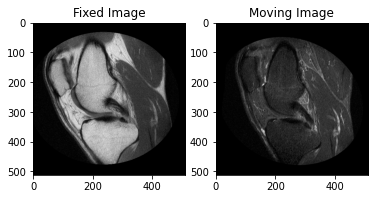

In [2]:
from google.colab import drive
drive.mount('/content/drive')

I = io.imread("/content/drive/My Drive/MM803/Assignment2/knee1.bmp").astype(np.float32)/255.0 # fixed image
J = io.imread("/content/drive/My Drive/MM803/Assignment2/knee2.bmp").astype(np.float32)/255.0 # moving image

nChannel = 1 # gray scale image

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(I,cmap="gray")
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(J,cmap="gray")
plt.title("Moving Image")
  

In [3]:
L = 6 # Gaussian pyramid level
downscale = 2.0 # downscale factor for the gaussian pyramid
pyramid_I = tuple(pyramid_gaussian(I, downscale=downscale, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(J, downscale=downscale, multichannel=False))

# create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,h_lst,w_lst,xy_lst,ind_lst=[],[],[],[],[],[]
for s in range(L):
  I_, J_ = torch.tensor(pyramid_I[s].astype(np.float32)).to(device), torch.tensor(pyramid_J[s].astype(np.float32)).to(device)
  I_lst.append(I_)
  J_lst.append(J_)
  h_, w_ = I_lst[s].shape[0], I_lst[s].shape[1]
  ind_ = torch.randperm(h_*w_).to(device)
  ind_lst.append(ind_)

  print(h_,w_,len(ind_))
  h_lst.append(h_)
  w_lst.append(w_)

  y_, x_ = torch.meshgrid([torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
  y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
  xy_ = torch.stack([x_,y_],2)
  xy_lst.append(xy_)


512 512 262144
256 256 65536
128 128 16384
64 64 4096
32 32 1024
16 16 256


In [4]:
class HomographyNet(nn.Module):
  def __init__(self):
    super(HomographyNet, self).__init__()
    # perspective transform basis matrices

    self.B = torch.zeros(8,3,3).to(device)
    self.B[0,0,2] = 1.0
    self.B[1,1,2] = 1.0
    self.B[2,0,1] = 1.0
    self.B[3,1,0] = 1.0
    self.B[4,0,0], self.B[4,1,1] = 1.0, -1.0
    self.B[5,1,1], self.B[5,2,2] = -1.0, 1.0
    self.B[6,2,0] = 1.0
    self.B[7,2,1] = 1.0

    self.v = torch.nn.Parameter(torch.zeros(8,1,1).to(device), requires_grad=True)

  def forward(self):
    return MatrixExp(self.B,self.v)

def MatrixExp(B,v):
    C = torch.sum(B*v,0)
    A = torch.eye(3).to(device)
    H = torch.eye(3).to(device)
    for i in torch.arange(1,10):
        A = torch.mm(A/i,C)
        H = H + A
    return H

In [5]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [6]:
def PerspectiveWarping(I, H, xv, yv):

  # apply transformation in the homogeneous coordinates
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0),align_corners=False).squeeze()
  return J

In [7]:
def multi_resolution_SSIM_loss():
  loss=0.0
  for s in np.arange(L-1,-1,-1):
    Jw_ = PerspectiveWarping(J_lst[s].unsqueeze(0).unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
    new_I = I_lst[s].unsqueeze(0).unsqueeze(0)
    new_J = Jw_.unsqueeze(0).unsqueeze(0)
    ssim_out  = -ssim_loss(new_I, new_J)
    loss = loss + (1./L)*ssim_out
    ssim_value = - ssim_out.data
  return loss, ssim_value

In [9]:
homography_net = HomographyNet().to(device)
ssim_loss  = SSIM()
optimizer = optim.Adam([{'params': homography_net.v, 'lr': 1e-2}], amsgrad=True)

for itr in range(100):
  optimizer.zero_grad()
  loss, ssim_value = multi_resolution_SSIM_loss()
  if itr%10 == 0:
    print("Itr:",itr,"SSIM value:","{:.4f}".format(ssim_value))
  loss.backward()
  optimizer.step()
print("Itr:",itr+1,"SSIM value:","{:.4f}".format(ssim_value))

Itr: 0 SSIM value: 0.4863
Itr: 10 SSIM value: 0.5234
Itr: 20 SSIM value: 0.5943
Itr: 30 SSIM value: 0.6345
Itr: 40 SSIM value: 0.6441
Itr: 50 SSIM value: 0.6486
Itr: 60 SSIM value: 0.6521
Itr: 70 SSIM value: 0.6535
Itr: 80 SSIM value: 0.6545
Itr: 90 SSIM value: 0.6550
Itr: 100 SSIM value: 0.6548


SSIM value before registration: 0.4815
SSIM value after registration: 0.6548
Transformation matrix:
[[ 0.9810061  -0.09466131  0.05136093]
 [ 0.17987795  0.9692209   0.05537755]
 [ 0.00322841  0.00237728  1.0335239 ]]



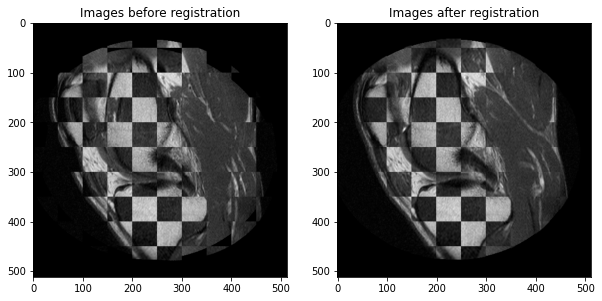

In [10]:
def histogram_SSIM(image1, image2):
  img1 = torch.from_numpy(image1).unsqueeze(0).unsqueeze(0)
  img2 = torch.from_numpy(image2).unsqueeze(0).unsqueeze(0)
  return ssim(img1, img2)


I_t = torch.tensor(I).to(device)
J_t = torch.tensor(J).to(device)
H = homography_net()
J_w = PerspectiveWarping(J_t.unsqueeze(0).unsqueeze(0), H, xy_lst[0][:, :, 0], xy_lst[0][:, :, 1]).squeeze()

D = J_t - I_t
D_w = J_w - I_t

print("SSIM value before registration:", "{:.4f}".format(histogram_SSIM(I, J)))
print("SSIM value after registration:", "{:.4f}".format(histogram_SSIM(I, J_w.cpu().detach().numpy())))

print("Transformation matrix:")
print(H.cpu().detach().numpy())
print("")

Ra = I_t.clone()
Rb = I_t.clone()
b = 50
for i in torch.arange(0, I_t.shape[0] / b, 1).int():
  for j in torch.arange(i % 2, np.floor(I_t.shape[1] / b), 2).int():
    Rb[i * b:(i + 1) * b, j * b:(j + 1) * b] = J_t[i * b:(i + 1) * b, j * b:(j + 1) * b].clone()
    Ra[i * b:(i + 1) * b, j * b:(j + 1) * b] = J_w[i * b:(i + 1) * b, j * b:(j + 1) * b].clone()

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(Rb.cpu().data, cmap="gray")
plt.title("Images before registration")
fig.add_subplot(1, 2, 2)
plt.imshow(Ra.cpu().data, cmap="gray")
plt.title("Images after registration")
plt.show()